# FuncADL: Functional Analysis Description Language

## Motivation

### Query languages

Database management systems help to address, among other issues:

- data independence
  - The concept that the physical schema of data (how the data is actually stored--file format, file location, storage medium) is independent from the logical schema (what is stored--floating point numbers representing the $p_T$ in GeV of each muon in each event). Therefore the way that you specify or *query* data should not be tied to any of the details of physical schema. In other words, the query should look exactly the same whether the data is in a ROOT file on the LHC computing grid or in a Parquet file stored on your local drive. This has certainly not been the case for most HEP software.
- data redundancy
  - Storing multiple indpendent copies of the same data. We see this all the time in HEP, mainly due to file formats at different levels of event detail (original AODs vs. DAODs in ATLAS, MiniAODs vs. NanoAODs in CMS, etc.) Storage requirements increase linearly with more copies of data. In addition, the more independent copies that exist of data, the more complicated it becomes to make sure they all match. In a good database system, data may be *physically* backed up with multiple copies, but there is only ever one *logical* version of the data. When you execute a query, you're not making a brand new copy of the data that then has to be maintained; you just get a *view* of the data as stored in the database.
  
A key aspect of database management is query languages, such as SQL.

### Functional languages

Functional programming offers several desirable features for physics analyses:
  - Declarative: Effectively the code equivalent of "independence"--*what* the code does can and should be separated from *how* the system does it. Instead of explicitly telling the computer to loop over each event, to loop over each muon in the event, and then to access the $p_T$ for each muon, you can just *declare* what you actually want: the $p_T$ of all muons. The program executing this query is free to get this information however it chooses. Similar to a compiler, the execution engine can be designed to fully optimize the actual IO and computation necessary to perform the query. In this way, a physicist just running an analysis doesn't need to worry about caching or advanced CPU instructions to benefit from the advantages they can provide.
  - Stateless: Pure functional languages have no "side effects". Modifying a global variable is an example of a side effect; it changes the global state. If there is no state, the result of a particular function is always exactly the same, regardless of where it is in the code. Thus the operations performed by a function are truly independent from any other function that it doesn't call.
  - Lazy: As in lazy execution. A query is itself a well-defined object, simply containing instructions (a *function*) for what to do with data. You can pass around and compose queries before even having access to the data it will run on. A query isn't actually executed until necessary.

Both of these concepts (query languages and functional languages) lead to more modular code:
  - Insulate analysis code from data storage location and file format
  - Insulate each section of code from other parts of the code

FuncADL is a functional data query language using Python as a host language, based on [LINQ](https://docs.microsoft.com/en-us/dotnet/csharp/programming-guide/concepts/linq/), a collection of features built into C#.

## Module setup

I'll use standard Matplotlib to make plots:

In [97]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200 # make figures bigger and more readable

The object we need to run FuncADL locally is `UprootDataset`:

In [98]:
from func_adl_uproot import UprootDataset

This explicitly tells FuncADL that we want to use the Uproot-based backend.

## Dataset

The dataset I use here is CMS open data converted to NanoAOD format, available via xrootd. `UprootDataset` expects a file location and a tree name:

In [99]:
ds = UprootDataset('Run2012B_SingleMu_10000.root', 'Events')

Now we have a dataset ready to run FuncADL queries on.

## Writing queries

In the rest of the notebook, I'll be introducing new query operators and then showing how they apply to some [benchmark tasks](https://github.com/iris-hep/adl-benchmarks-index) that have been developed by the HEP Software Foundation and IRIS-HEP to demonstrate the core functionality of different analysis description languages.

## Some basics

The most important thing to understand is that nearly everything in FuncADL is simply treated as a sequence of elements. Arrays are sequences of rows. For example, the dataset object is just a sequence of event objects. An event object is a dictionary containing all of the properties of the event, whose values either are primitive types like `int`s or `float`s or are sequences themselves. Thus almost all FuncADL operators expect to act on a sequence.

## Select

The most common operator is `Select`. `Select` transforms each element of a sequence according to some predicate function and returns the sequence formed by all the tranformed elements. It's basically a generic `map()`.

Visually, it does this:

```
[1, 2, 3].Select(lambda x: x + 1) -> [2, 3, 4]
```

This operator is all we need for the first benchmark task.

## Task 1: Plot the <i>E</i><sub>T</sub><sup>miss</sup> of all events.

MET is in the branch `MET_pt`.

In [100]:
missing_ET_query = ds.Select(lambda event: event.MET_pt)

This didn't actually do anything yet. FuncADL uses delayed execution, so the value won't be calculated until we run `.value()`:

In [101]:
%%time

missing_ET = missing_ET_query.value()

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 128 ms


Now we've actually stored the result:

In [102]:
missing_ET

<Array [22.2, 13.9, 15, ... 14.4, 26.5, 19.3] type='10000 * float32'>

And we can plot it:

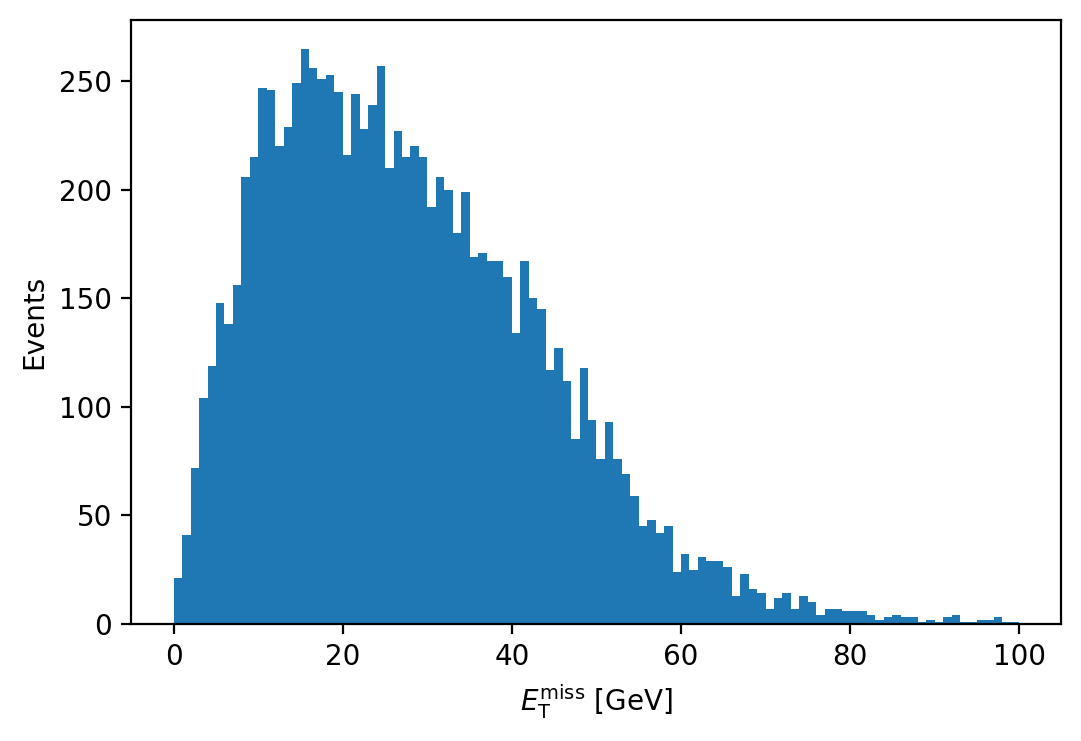

In [103]:
plt.hist([missing_ET], bins=100, range=(0, 100))
plt.xlabel(r'$E_\mathrm{T}^\mathrm{miss}$ [GeV]')
plt.ylabel('Events')
plt.show()

## SelectMany

`SelectMany` is an operator that starts by doing exactly the same thing as `Select`, but it assumes that each element in the sequence gets mapped to a sequence itself, and after performing the mapping, it concatenates all of these sequences.

Visually:

```
[1, 2, 3].SelectMany(lambda x: [x - 1, x + 1]) -> [0, 2, 1, 3, 2, 4]
```

In the intermiate step, `SelectMany` forms the sequence `[0, 2], [1, 3], [2, 4]` and then concatenates all of these together.

Often this operator is used when the elements were already sequences, so that we can just flatten an array:

```
[[1, 2], [3]].SelectMany(lambda s: s) -> [1, 2, 3]
```

`SelectMany` is the only operator needed for the second task.

## Task 2: Plot the <i>p</i><sub>T</sub> of all jets.

In [104]:
jet_pT = ds.SelectMany(lambda event: event.Jet_pt).value()

In [105]:
jet_pT

<Array [71.7, 27.8, 23.2, ... 30.2, 22.6, 21.6] type='16840 * float32'>

Note the difference between the above result and the unflattened result we'd get from just `Select`:

In [106]:
ds.Select(lambda event: event.Jet_pt).value()

<Array [[71.7, 27.8], [23.2, ... 21.6], [], []] type='10000 * var * float32'>

This is a sequence of sequences--a jagged array. In principle we could have used this for this particular task; we just would have needed to manually call `ak.flatten` on the array afterwards.

Now we can plot the `SelectMany` result:

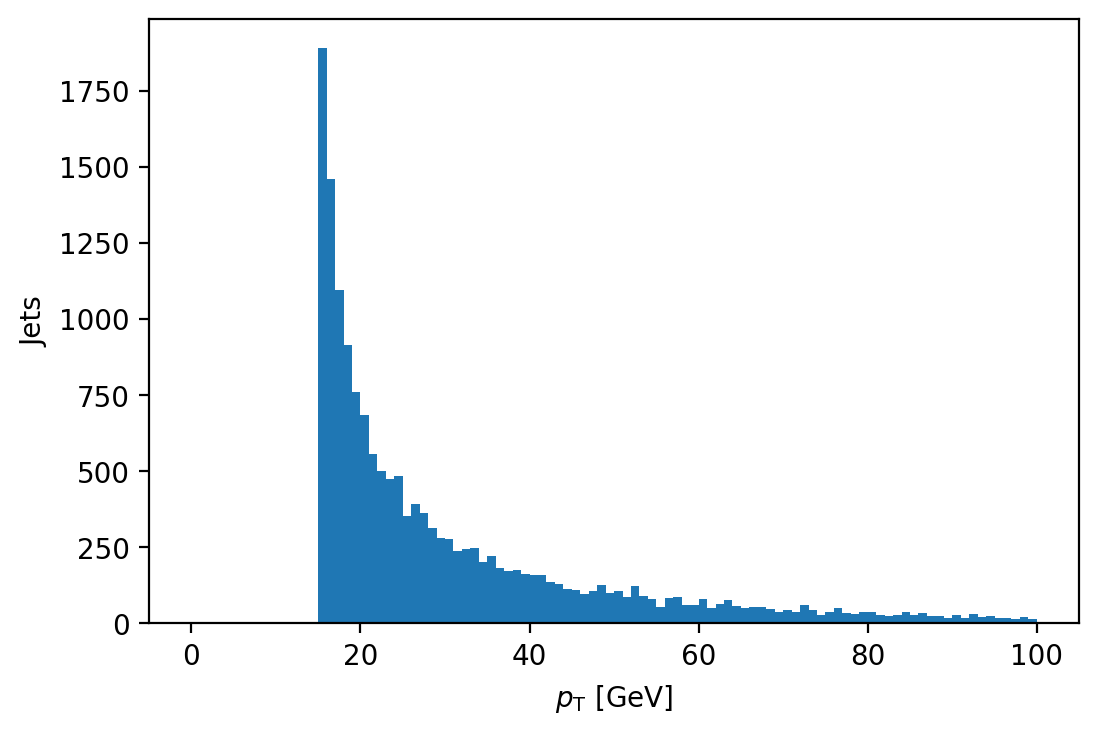

In [107]:
plt.hist([jet_pT], bins=100, range=(0, 100))
plt.xlabel(r'$p_\mathrm{T}$ [GeV]')
plt.ylabel('Jets')
plt.show()

## Where

With `Select` and `SelectMany`, we can already filter out event properties (branches) that we aren't interested in. But what if we want to filter out certain events or jets? We need to discard elements of a sequence to do this. This is done by the `Where` operator. `Where` applies a boolean-valued function to each element and discards that element if the function returned `False`.

Visually, we have:
```
[1, -2, 3].Where(lambda x: x > 0) -> [1, 3]
```

## Zip

When we start dealing with sequences within events (like jets) in more detail, we'll need to somehow wrap together multiple properties that correspond to the same physical objects. That way when we make a selection cut on jet `pT` for example, we'll be filtering the corresponding `eta`, `phi`, and `mass` values too. To do this, we use the `Zip` operator. `Zip` expects a sequence of sequences, and it will make a new sequence out of all the elements at each particular index of the sequences. In other words, it transposes the matrix formed by the input sequences.

So this looks like:
```
[[1, 3, 5], [2, 4, 6]].Zip() -> [[1, 2], [3, 4], [5, 6]]
```

But usually this is actually done with a dictionary, which is just a special type of sequence:
```
{'a': [1, 3, 5], 'b': [2, 4, 6]}.Zip() -> [{'a': 1, 'b': 2}, {'a': 3, 'b': 4}, {'a': 5, 'b': 6}]
```

In `awkward` language, this turns a record of arrays into an array of records.

The next task requires looking a jet variable other than the one used for filtering, so we can use `Zip` here.

## Task 3: Plot the <i>p</i><sub>T</sub> of jets with |<i>η</i>| < 1.

In [108]:
filtered_jet_pT = ds.SelectMany(lambda event: {'pT': event.Jet_pt, 'eta': event.Jet_eta}.Zip()
                                              .Where(lambda jet: abs(jet.eta) < 1)
                                              .Select(lambda jet: jet.pT)).value()

Note that builtin functions like `abs` are allowed in queries.

In [109]:
filtered_jet_pT

<Array [27.8, 17.4, 33.7, ... 31.6, 30.2, 22.6] type='6436 * float32'>

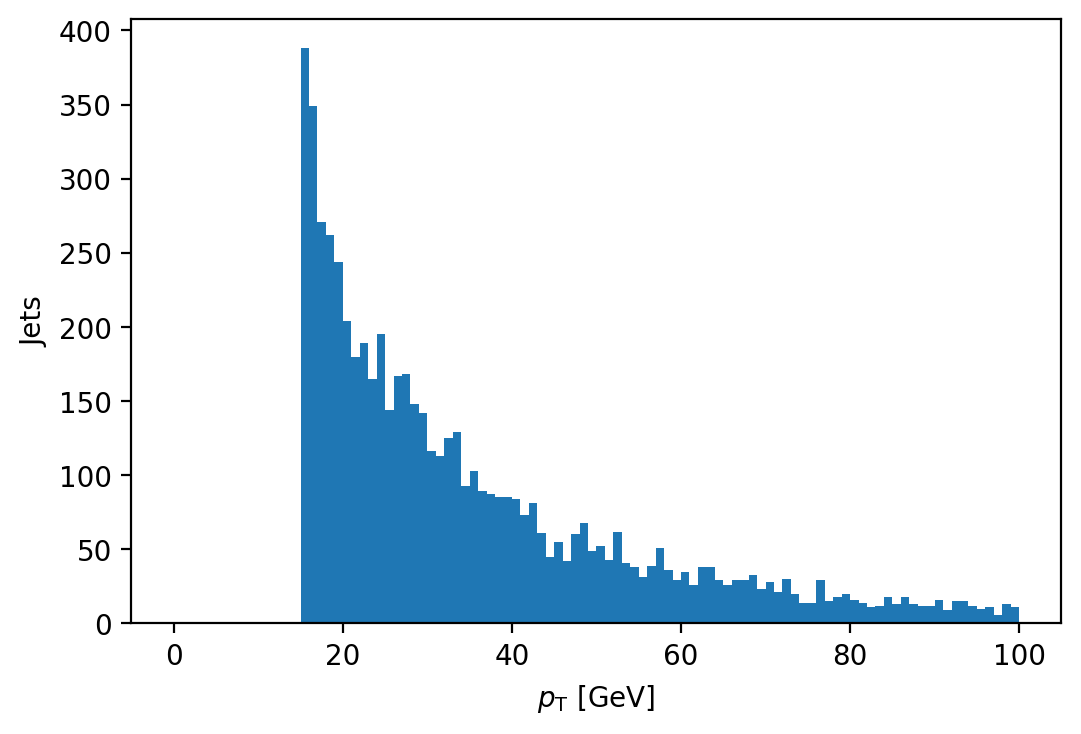

In [110]:
plt.hist([filtered_jet_pT], bins=100, range=(0, 100))
plt.xlabel(r'$p_\mathrm{T}$ [GeV]')
plt.ylabel('Jets')
plt.show()

## Count

Next we're going to need to filter based on a discrete number of objects passing some cut. `Count` is an operator that takes a sequence and just returns a scalar--the length of the sequence.

```
[0, 2, 5].Count() -> 3
```

## Task 4: Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have at least two jets with <i>p</i><sub>T</sub> > 40 GeV.

In [111]:
filtered_missing_ET_4 = ds.Where(lambda event: event.Jet_pt.Where(lambda pT: pT > 40).Count() >= 2)\
                          .Select(lambda event: event.MET_pt).value()

In [112]:
filtered_missing_ET_4

<Array [15, 44.7, 30.5, ... 22, 18.7, 19.2] type='1161 * float32'>

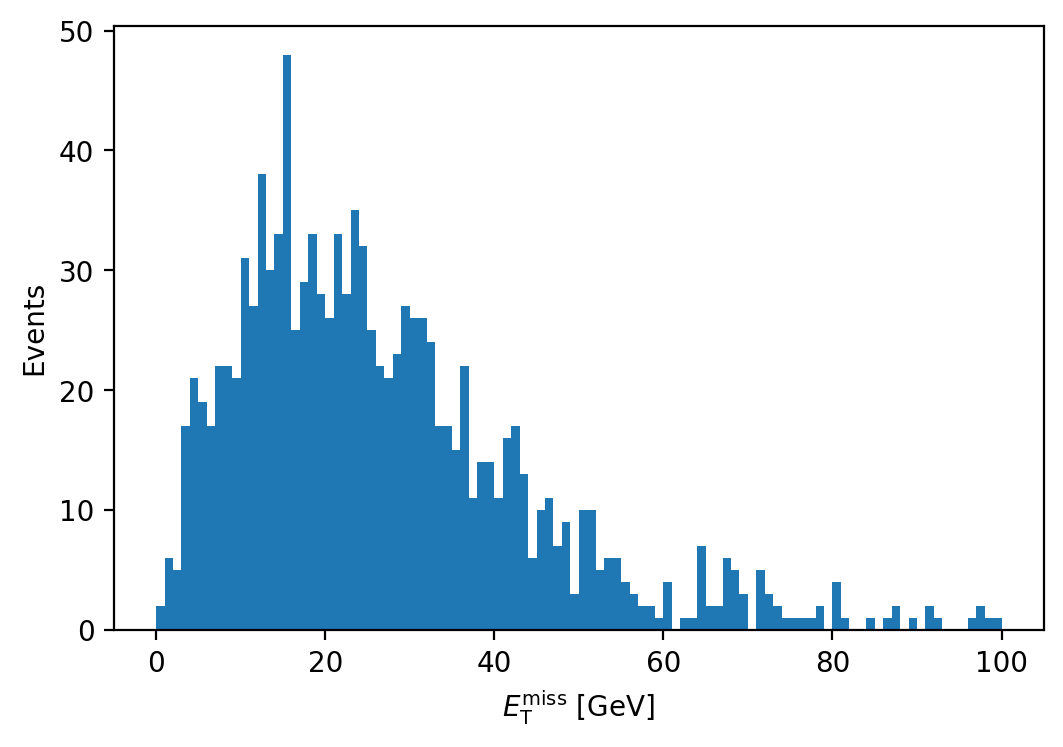

In [113]:
plt.hist([filtered_missing_ET_4], bins=100, range=(0, 100))
plt.xlabel(r'$E_\mathrm{T}^\mathrm{miss}$ [GeV]')
plt.ylabel('Events')
plt.show()

## Choose

Dealing with combinatorics is a common issue in HEP analyses. `Choose` is an operator that takes a sequence and produces all combinations of a given number of elements (think "n choose k" like $\binom{n}{k}$).

```
[1, 2, 3].Choose(2) -> [[1, 2], [1, 3], [2, 3]]
```

## ToFourMomenta

Dealing with four-vectors is another nearly ubiquitous aspect of HEP analysis, but ntuples usually have the components of vectors in seperate `float` branches, rather than as four-vector objects. To accomodate this in `func_adl_uproot`, I've added a `ToFourMomenta` operator that uses scikit-hep/vector to create the vector objects and perform four-vector operations within FuncADL.

```
[{'pt': pt1, 'eta': eta1, 'phi': phi1', 'mass': mass1},
 {'pt': pt2, 'eta': eta2, 'phi': phi2', 'mass': mass2},
 ...].ToFourMomenta() -> [four_vector1, four_vector2, ...]
```

## Task 5: Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have an opposite-charge muon pair with an invariant mass between 60 and 120 GeV.

In [114]:
filtered_missing_ET_5 = ds.Where(lambda event: Zip({'p4': Zip({'pt':   event.Muon_pt,
                                                               'eta':  event.Muon_eta,
                                                               'phi':  event.Muon_phi,
                                                               'mass': event.Muon_mass}).ToFourMomenta(),
                                                    'charge': event.Muon_charge})
                                               .Choose(2)
                                               .Where(lambda pair: pair[0].charge * pair[1].charge < 0)
                                               .Select(lambda pair: (pair[0].p4 + pair[1].p4).mass)
                                               .Where(lambda mass: 60 < mass and mass < 120)
                                               .Count() > 0
                                ).Select(lambda event: event.MET_pt).value()

In [115]:
filtered_missing_ET_5

<Array [18.7, 13.3, 4.42, ... 13.2, 18.4, 7.06] type='543 * float32'>

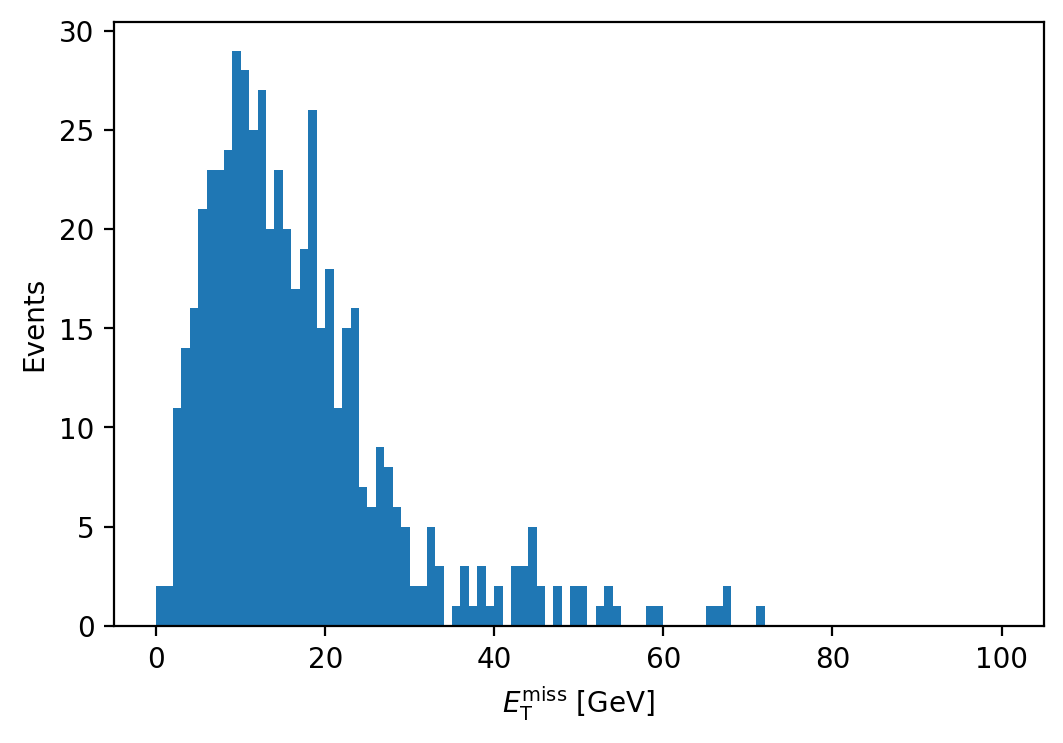

In [116]:
plt.hist([filtered_missing_ET_5], bins=100, range=(0, 100))
plt.xlabel(r'$E_\mathrm{T}^\mathrm{miss}$ [GeV]')
plt.ylabel('Events')
plt.show()

## OrderBy

Sorting can be accomplished with `OrderBy` or `OrderByDescending`. These operators use the provided function to calculate the key to sort elements by.

```
[3, 1, 2].OrderBy(lambda x: x) -> [1, 2, 3]
[3, 1, 2].OrderBy(lambda x: -x) -> [3, 2, 1]
[3, 1, 2].OrderByDescending(lambda x: x) -> [3, 2, 1]
```

## First

`x.First()` is a synonym for `x[0]`. It just provides a more readable way to get the first element.

```
[1, 2, 3].First() -> 1
```

## Task 6: For events with at least three jets, plot the $p_T$ of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event.

In [117]:
best_trijet_pt_6 = ds.Where(lambda event: event.nJet >= 3)\
                     .Select(lambda event: {'pt': event.Jet_pt,
                                            'eta': event.Jet_eta,
                                            'phi': event.Jet_phi,
                                            'mass': event.Jet_mass}.Zip().ToFourMomenta()
                                           .Choose(3)
                                           .Select(lambda triplet: triplet[0] + triplet[1] + triplet[2])
                                           .OrderBy(lambda trijet: abs(trijet.m - 172.5))
                                           .First()
                                           .Select(lambda best_trijet: best_trijet.pt)).value()

In [118]:
best_trijet_pt_6

<Array [26, 33, 21.2, 34.7, ... 63.8, 41, 3.86] type='2660 * float32'>

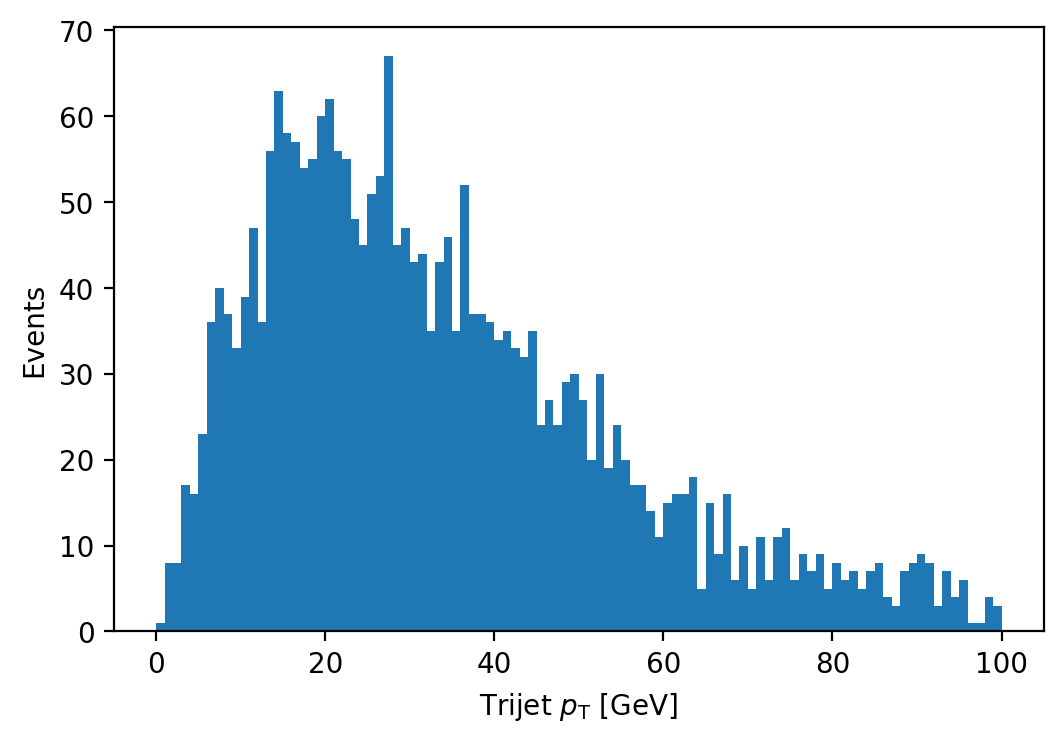

In [119]:
plt.hist(best_trijet_pt_6, bins=100, range=(0, 100))
plt.xlabel(r'Trijet $p_\mathrm{T}$ [GeV]')
plt.ylabel('Events')
plt.show()